In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2
import pathlib

In [ ]:
#a) Load the oxford_iiit_pet dataset

# Construct a tf.data.Dataset
train_ds, test_ds = tfds.load('oxford_iiit_pet', split=['train','test[:40%]'], shuffle_files=False)

In [21]:
def read_and_preprocess(data):
  input_image = tf.image.resize(data['image'], (128, 128), method=tf.image.ResizeMethod.AREA)
  input_mask = tf.image.resize(data['segmentation_mask'], (128, 128), method=tf.image.ResizeMethod.AREA)

  input_image = tf.image.convert_image_dtype(input_image, tf.float32) / 255 # normalizing image
  input_mask -= 1 # {1,2,3} to {0,1,2}
  print(input_mask)

  return input_image, input_mask

In [5]:
# applying function to all images in the dataset
train = train_ds.map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = test_ds.map(read_and_preprocess)

Tensor("sub:0", shape=(128, 128, 1), dtype=float32)
Tensor("sub:0", shape=(128, 128, 1), dtype=float32)


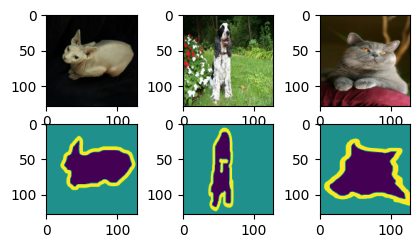

In [9]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version

plt.figure(figsize=(5, 4))
plt_index = 0
for image in train.take(3):
  ax = plt.subplot(3, 3, plt_index + 1)
  plt.xticks()
  plt.yticks()
  plt.imshow(image[0])
  plt_index = plt_index + 1


for image in train.take(3):
  ax = plt.subplot(3, 3, plt_index + 1)
  plt.xticks()
  plt.yticks()
  plt.imshow(image[1])
  plt_index = plt_index + 1

**Part 2- Annotation**

In [1]:
# Install mrcnn
!pip install mrcnn -q

# Get data from here https://github.com/experiencor/raccoon_dataset
# Clone to collaboration workspace
!git clone https://github.com/experiencor/raccoon_dataset.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 957.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 14.39 MiB/s, done.
Resolving deltas: 100% (412/412), done.


In [4]:
# initial attempt
# converting images from dataset into tensor trainsets
data_dir = "/content/raccoon_dataset/"
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                                labels="inferred",
                                                                validation_split=0.25,
                                                                subset="both",
                                                                seed=58,
                                                                image_size = (128, 128))

Found 200 files belonging to 4 classes.
Using 150 files for training.
Using 50 files for validation.


In [5]:
# Used solution
# Reading in local images using CV
data_dir = pathlib.Path('/content/raccoon_dataset')

# List of paths in dataset
ds_images = []
for sub_dir in data_dir.glob('*/'):
    if sub_dir.is_dir():
      dir_name = sub_dir.name
      # Iterate over image files in the subdirectory
      for image_path in sub_dir.glob('*.jpg'):
          # Append the image path to the list
        ds_images.append(image_path)
print("Number of Paths of images in dataset", len(ds_images))

Number of Paths of images in dataset 200


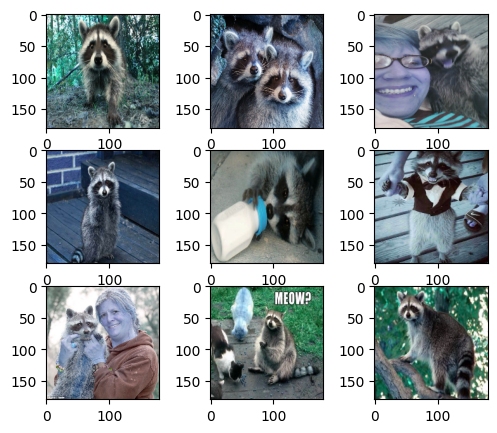

In [6]:
plt.figure(figsize=(6, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  # loading image
  image = cv2.imread(str(ds_images[i]))
  # Resizing image
  resized = cv2.resize(image, (180, 180))
  plt.imshow(resized)
  plt.axis("on")

plt.show()

In [7]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


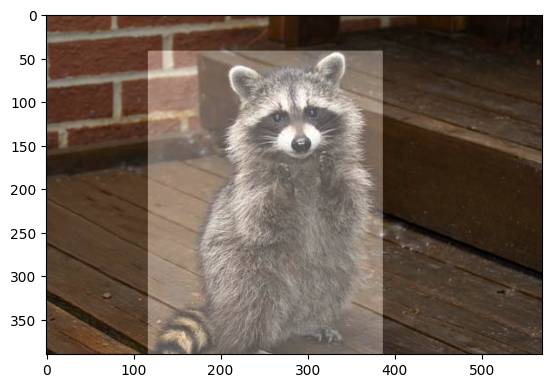

In [8]:
# load an image
# Use the function above to create the image and its mask

image_id = 3  # Change this to load a different image
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
plt.grid(False)
# Display the image
plt.imshow(image)

# Display the mask
for i in range(mask.shape[2]):
    plt.imshow(mask[:, :, i], cmap='gray', alpha=0.3, vmin=0, vmax=1)
plt.show()

**Part 3- YOLO 8**




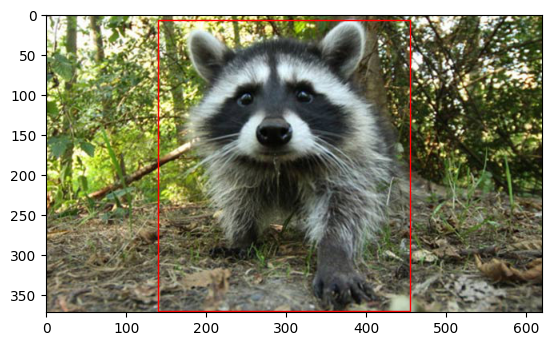

In [9]:
# a- Create annotation
# You can upload the file using ![title](filename.jpeg)
# import image module

import xml.etree.ElementTree as ET
import matplotlib.patches as patches
import PIL
from PIL import Image

# Function to extract bounding box information from XML
def extract_boxes(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])

    return boxes

# Function to visualize annotations on the image
def visualize_annotations(image_path, annotation_boxes):
    # Open the image
    image = Image.open(image_path)

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)
    plt.grid(False)
    plt.axis('on')

    # Add bounding box annotations
    for box in annotation_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the image with annotations
    plt.show()

racoon_number = str(ds_images[0]).split('.')[0].split('/')[-1]
annotation_boxes = extract_boxes('/content/raccoon_dataset/annotations/'+ racoon_number + '.xml')
visualize_annotations(ds_images[0], annotation_boxes)

In [1]:
#b- Now, we want to install Yolo8.
# Download required tools
# Clone yolo 8 and check all dependencies

!pip install ultralytics==8.0.20 -q
!pip install --upgrade ultralytics -q

from IPython import display
from IPython.display import Image
display.clear_output()
import ultralytics
from ultralytics import YOLO
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
ultralytics.checks()

Ultralytics YOLOv8.0.209 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.8/107.7 GB disk)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
ultralytics.checks()

Ultralytics YOLOv8.0.209 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.8/107.7 GB disk)


In [1]:
# Load the pre-trained models (yolov8n.yaml and yolov8n.pt)
bus_jpg = 'https://ultralytics.com/images/bus.jpg'
model = YOLO(f'yolov8n.pt')
# model = YOLO(f'yolov8n.yaml')

NameError: ignored

In [150]:
!rm /content/runs -rf runs/

In [ ]:
#c- Train the model here
# Follow the Github instruction to train a YOLO8 model here

# tried to train the
# model.train(epochs=3)
model.train(data="coco128.yaml", epochs=3)  # train the model

Ultralytics YOLOv8.0.209 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco128.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int

In [186]:
#d- Test model
# Test this above trained model on an image. For example:
# Use the

from matplotlib.patches import Rectangle
from PIL import Image

results = model('/content/bus.jpg')
print(results)

for r in results:
  print(r.boxes)
  print(r.masks)
  print(r.probs)
  print(r.orig_shape)
  res =r.plot(pil=True)


# res_plotted = results[0].plot()
# cv2.imshow("result", res_plotted)

[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
type: <class 'torch.Tensor'>
shape: torch.Size([6, 6])
dtype: torch.float32
 + tensor([[2.00000e+01, 2.25000e+02, 8.03000e+02, 7.55000e+02, 8.61757e-01, 5.00000e+00],
        [4.70000e+01, 3.96000e+02, 2.47000e+02, 9.05000e+02, 8.54654e-01, 0.00000e+00],
        [6.69000e+02, 3.77000e+02, 8.10000e+02, 8.78000e+02, 8.32664e-01, 0.00000e+00],
        [2.21000e+02, 4.06000e+02, 3.44000e+02, 8.58000e+02, 7.82456e-01, 0.00000e+00],
        [0.00000e+00, 5.50000e+02, 6.40000e+01, 8.74000e+02, 3.33802e-01, 0.00000e+00],
        [0.00000e+00, 2.54000e+02, 3.20000e+01, 3.25000e+02, 3.23143e-01, 1.10000e+01]], device='cuda:0')]
tensor([[2.00000e+01, 2.25000e+02, 8.03000e+02, 7.55000e+02, 8.61757e-01, 5.00000e+00],
        [4.70000e+01, 3.96000e+02, 2.47000e+02, 9.05000e+02, 8.54654e-01, 0.00000e+00],
        [6.69000e+02, 3.77000e+02, 8.10000e+02, 8.78000e+02, 8.32664e-01, 0.00000e+00],
        [2.21000e+02, 4.06000e+02, 3.4

AttributeError: ignored

In [ ]:
model.predict("/content/bus.jpg", save=True, imgsz=320, conf=0.5)

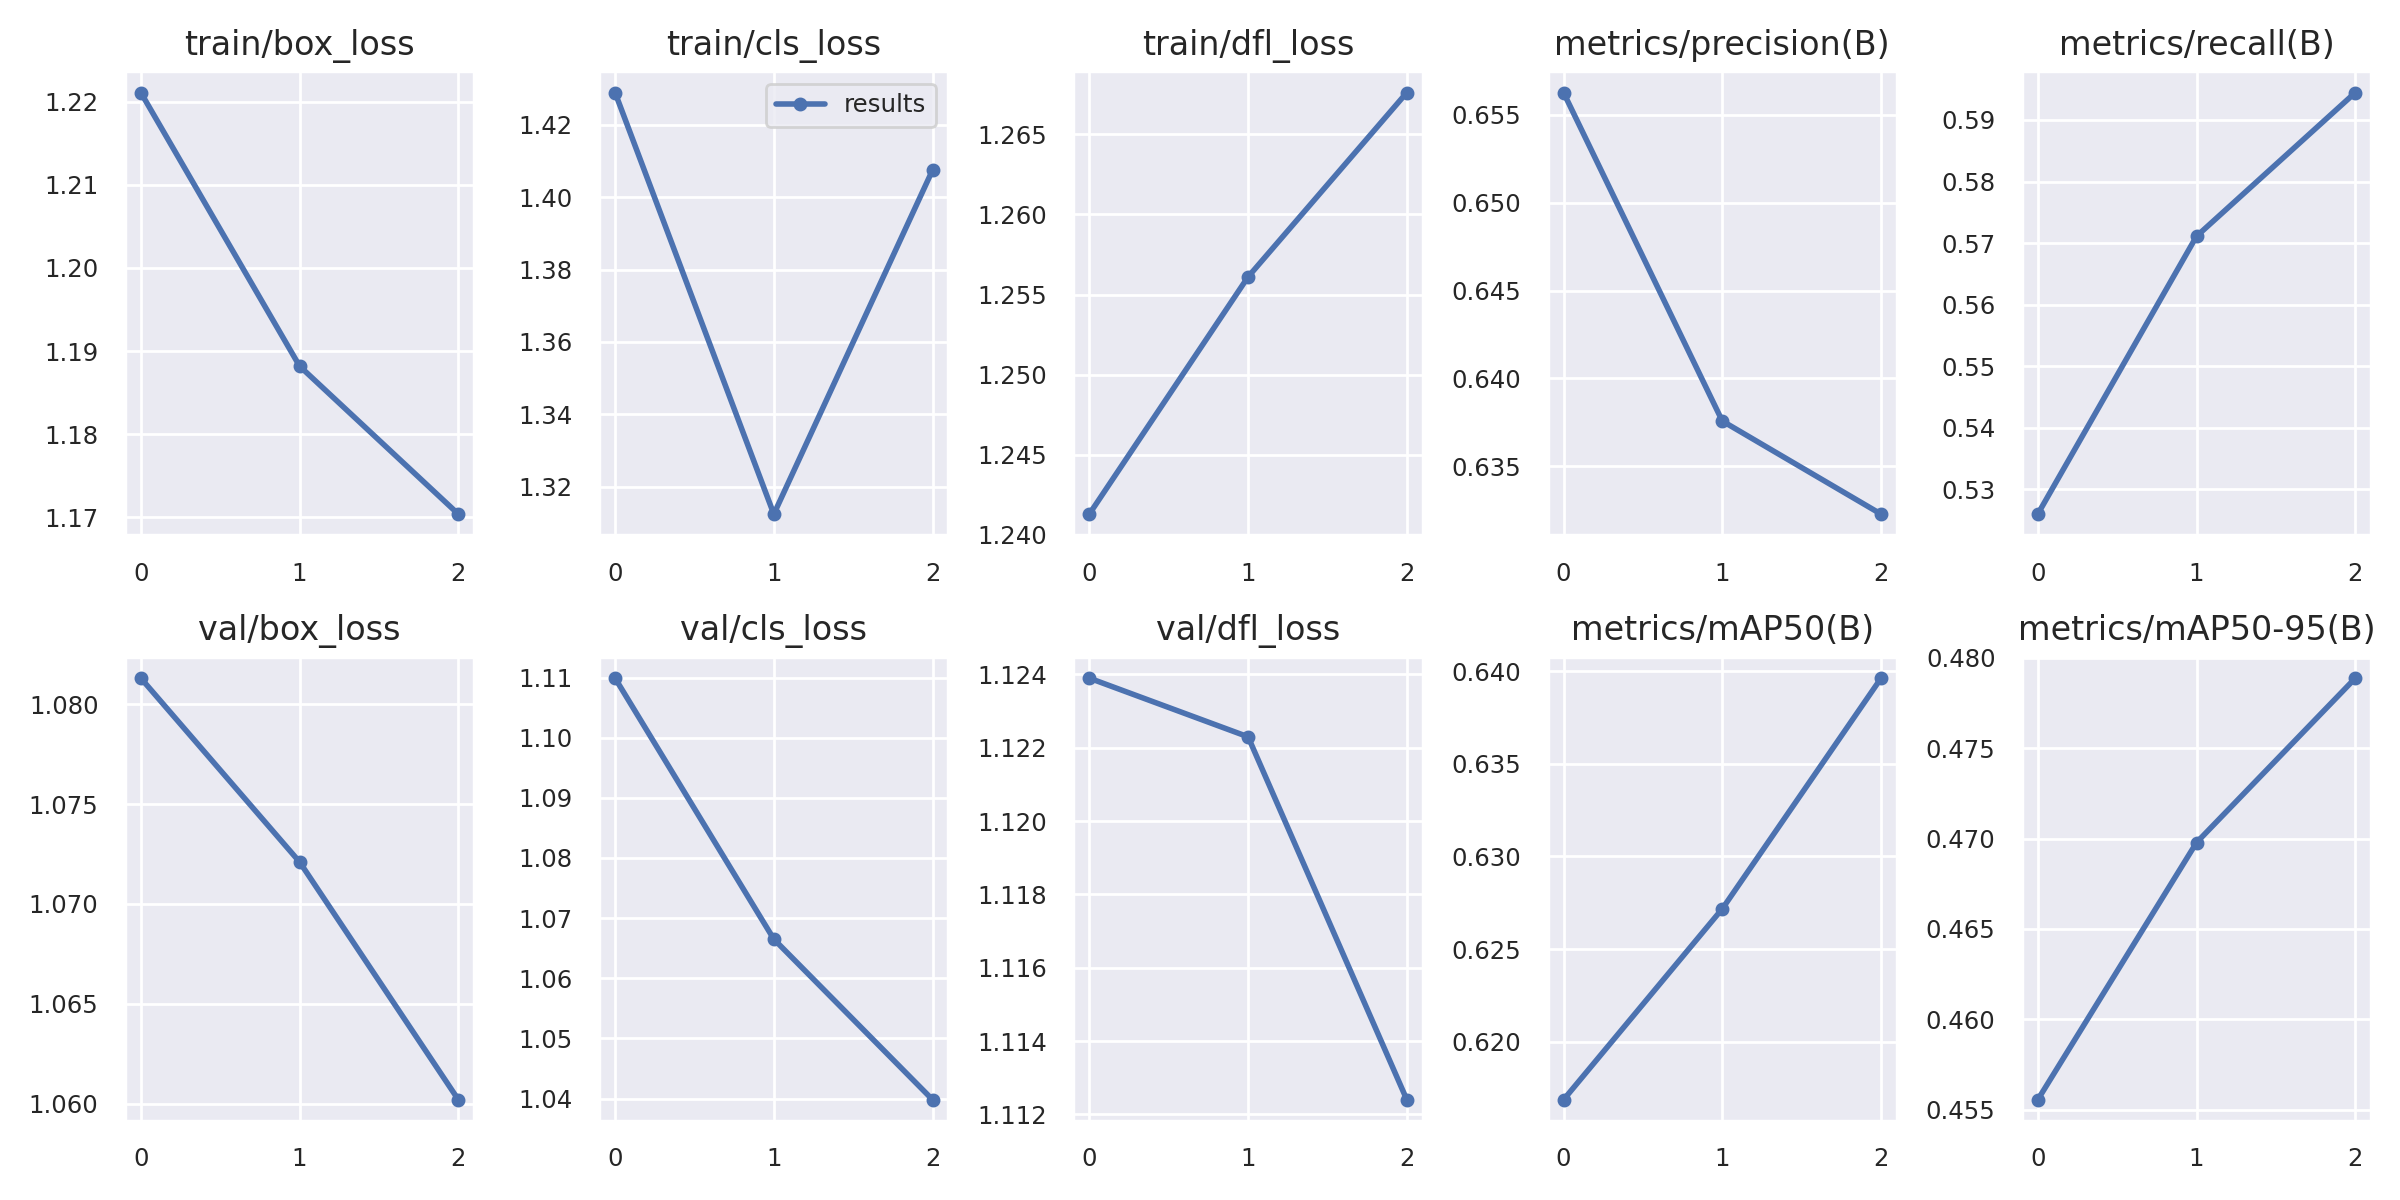

In [155]:
# e- See the result.
# Show the result and all the assigned objects

Image(filename=f'/content/runs/detect/train/results.png', width=500)

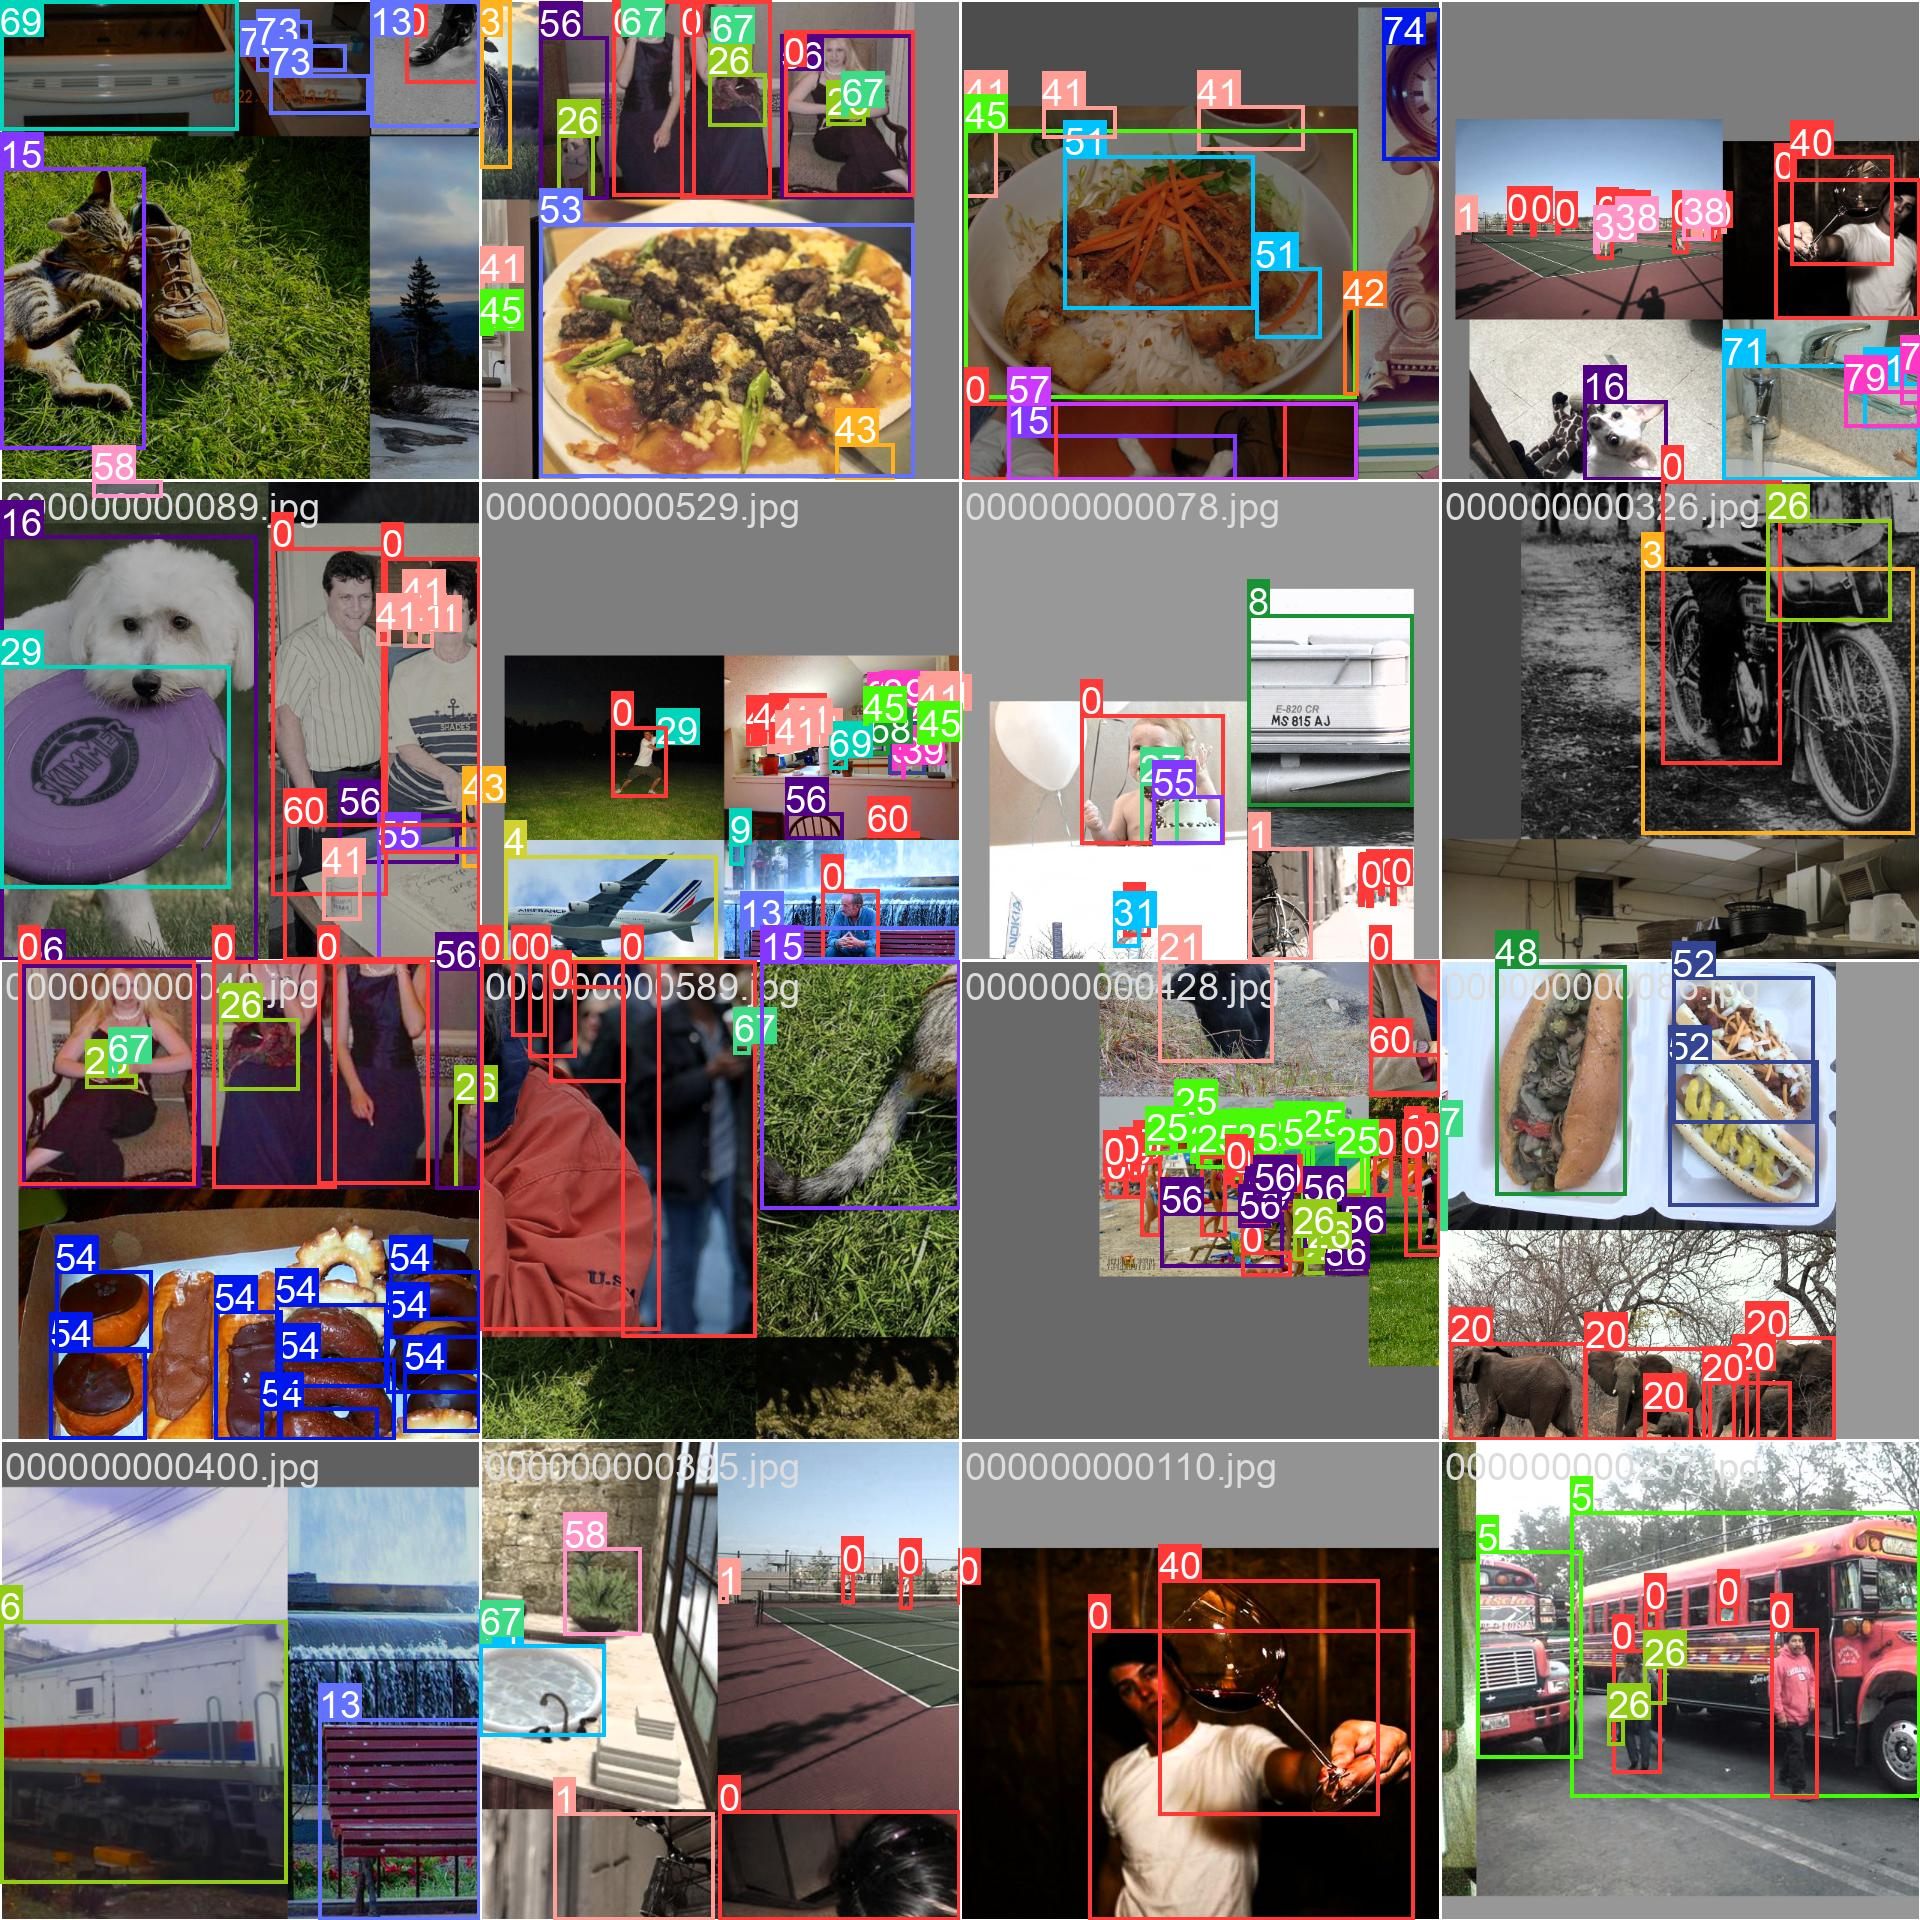

In [156]:
Image(filename=f'/content/runs/detect/train/train_batch0.jpg', width=400)

In [157]:
Image(filename=f'/content/runs/detect/val/val_batch2_labels.jpg', width=500)

FileNotFoundError: ignored

In [ ]:
# What is your understanding from this image? What is the meaning of these numbers all over the image?

My understanding from the two multi images printed is that in the first image, the objects in the image are bounded and given an annotation number that corresponds with the classification class that object belongs too. This is one of the batches used to train the model.

In second image, the images are still bounded but now they are actually reflecting the class name, and not the annotation number.


In [132]:
# Colab2PDF v1.0.2 by Drengskapur (github.com/drengskapur/colab2pdf) (License: GPL-3.0-or-later)
# @title {display-mode:"form"}
# @markdown ⬇️ Download PDF
def colab2pdf():
    ENABLE=True # @param {type:"boolean"}
    if ENABLE:
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))
colab2pdf()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>